In [1164]:
import numpy as np
import matplotlib.pyplot as plt

In [1165]:
import time
import json

In [1166]:
import pulp
#solver_list = pulp.listSolvers(onlyAvailable=True)
#print(solver_list)
#['CPLEX_PY', 'PULP_CBC_CMD']

In [1167]:
result_log = {'method':'revisit',
              'case':f'run_{int(time.time())}'}
result_log

{'method': 'revisit', 'case': 'run_1723831518'}

In [1168]:
length_x = 1
length_y = 1

In [1169]:
x_points = np.linspace(0,length_x,100)
y_points = np.linspace(0,length_y,100)

In [1170]:
x_grid, y_grid = np.meshgrid(x_points,y_points)

In [1171]:
def f_func(x,y,k1,k2,length_x,length_y):
    return np.cos(k1*np.pi*x/length_x)*np.cos(k2*np.pi*y/length_y)

In [1172]:
max_wave = 3
wave_numbers = [(i,j) for i in range(max_wave) for j in range(max_wave)]
wave_numbers

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [1173]:
result_log['wave_numbers']=wave_numbers

In [1174]:
def inner_product(f1,f2):
    assert f1.shape==f2.shape
    return np.sum(f1*f2,axis=None)/(f1.size)

In [1175]:
basis = {}
for k in wave_numbers:
    f_raw = f_func(x_grid,y_grid,k[0],k[1],length_x,length_y)
    h = np.sqrt(inner_product(f_raw,f_raw))
    basis[k] = f_raw/h

In [1176]:
inner_product(basis[(0,1)],basis[(1,1)])

-6.217248937900877e-17

In [1177]:
inner_product(basis[(1,1)],basis[(1,1)])

1.0

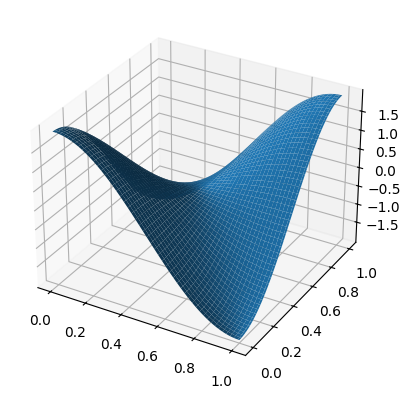

In [1178]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,basis[(1,1)])

In [1179]:
my_mean = np.array([0.5,0.5])
my_cov = np.array([[0.01,0.02],[-0.04,0.08]])
my_inv_cov = np.linalg.inv(my_cov)
my_det_cov = np.linalg.det(my_cov)

In [1180]:
my_pdf = np.zeros_like(x_grid)
for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        xij = x_grid[i,j]
        yij = y_grid[i,j]
        vij = np.array([xij,yij])
        fij = np.exp(-0.5*np.transpose((vij-my_mean))@my_inv_cov@(vij-my_mean))/np.sqrt(4*np.pi*np.pi*my_det_cov)
        my_pdf[i,j] = fij
result_log['pdf']='gaussian'

In [1181]:
my_pdf = np.zeros_like(x_grid)
my_mean = np.array([0.75,0.25])
my_cov = np.array([[0.01,0.01],[-0.01,0.01]])
my_inv_cov = np.linalg.inv(my_cov)
my_det_cov = np.linalg.det(my_cov)
for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        xij = x_grid[i,j]
        yij = y_grid[i,j]
        vij = np.array([xij,yij])
        fij = np.exp(-0.5*np.transpose((vij-my_mean))@my_inv_cov@(vij-my_mean))/np.sqrt(4*np.pi*np.pi*my_det_cov)
        my_pdf[i,j] = fij
my_mean = np.array([0.5,0.65])
my_cov = np.array([[0.04,0.0],[-0.0,0.01]])
my_inv_cov = np.linalg.inv(my_cov)
my_det_cov = np.linalg.det(my_cov)
for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        xij = x_grid[i,j]
        yij = y_grid[i,j]
        vij = np.array([xij,yij])
        fij = np.exp(-0.5*np.transpose((vij-my_mean))@my_inv_cov@(vij-my_mean))/np.sqrt(4*np.pi*np.pi*my_det_cov)
        my_pdf[i,j] = my_pdf[i,j] + fij
result_log['pdf']='gaussian-mix'

In [1182]:
# optional overwrite with uniform
#my_pdf = np.ones_like(x_grid)/(length_x*length_y)
#result_log['pdf']='uniform'

In [1183]:
# uniform in a subset
#my_pdf = (x_grid**2 + y_grid**2 >= 0.6)
#result_log['pdf']='uniform-hole'

In [1184]:
# made up
my_pdf = 1-np.cos(4*np.pi*np.maximum(np.maximum(x_grid-0.5,np.zeros_like(x_grid)),
                                     np.maximum(y_grid-0.5,np.zeros_like(x_grid))))
result_log['pdf']='cosine-ridges-2'

In [1185]:
# gentle bias to one side
#my_pdf = 0.7 + np.sqrt(x_grid) + 0.3*np.sqrt(y_grid)
#result_log['pdf']='bias-northeast'

In [1186]:
my_pdf = my_pdf/inner_product(my_pdf,basis[(0,0)])

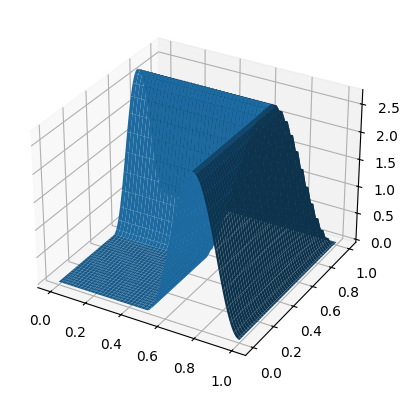

In [1187]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,my_pdf)

In [1188]:
eta = {}
for k in wave_numbers:
    eta[k] = inner_product(my_pdf,basis[k])

In [1189]:
fourier_pdf = np.zeros_like(x_grid)
for k in wave_numbers:
    fourier_pdf += eta[k]*basis[k]

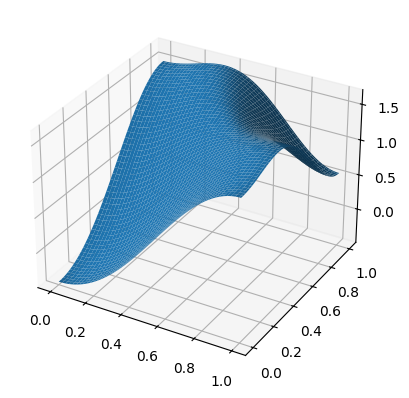

In [1190]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,fourier_pdf)

In [1191]:
wp_num_x = 8
wp_num_y = 8

In [1192]:
x_wp,y_wp = np.meshgrid(np.linspace(0,length_x,wp_num_x),np.linspace(0,length_x,wp_num_y))
result_log['mesh'] = f'square {wp_num_x}x{wp_num_y}'

In [1193]:
# convert to triangular mesh
#x_wp[1::2,:] = x_wp[1::2,:] + 0.5*length_x/(wp_num_x-1)
#x_wp = x_wp*(wp_num_x-1)/(wp_num_x-0.5)
#y_wp = y_wp*np.cos(np.pi/6.0)*(wp_num_x-1)/(wp_num_x-0.5)
#y_wp = y_wp + 0.5*length_y-np.median(y_wp,axis=None)
#result_log['mesh'] = f'tri {wp_num_x}x{wp_num_y}'

In [1194]:
num_wp = wp_num_x*wp_num_y

In [1195]:
wp_array = np.vstack((np.reshape(x_wp,(1,x_wp.size)),np.reshape(y_wp,(1,y_wp.size))))

In [1196]:
links = [(i,j) for i in range(x_wp.size) for j in range(x_wp.size) if i!=j and np.linalg.norm(wp_array[:,i] - wp_array[:,j])<=1.1*length_x/(wp_num_x-1)]
print(f'There are {len(links)} links')

There are 224 links


In [1197]:
#links = [(i,j) for (i,j) in links if i!=58 and j!=58]
#result_log['mesh'] = result_log['mesh'] + ' + hole'

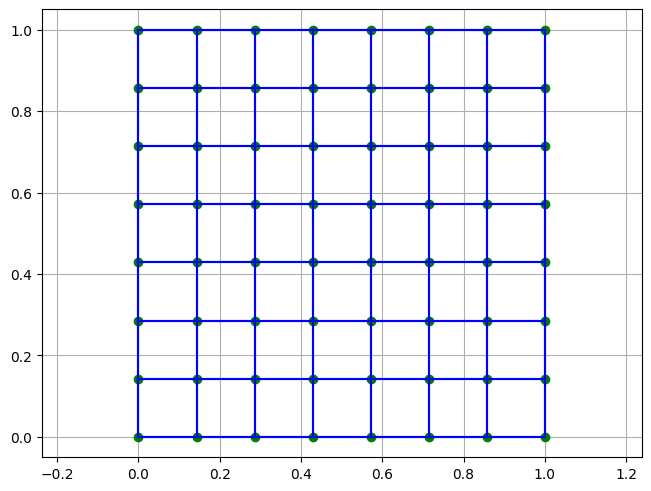

In [1198]:
fig,ax = plt.subplots(layout='constrained')
ax.plot(x_wp,y_wp,'go')
for (i,j) in links:
    if i!=-1 and j!=-1:
        plt.plot(wp_array[0,[i,j]],wp_array[1,[i,j]],'b-')
ax.axis('equal')
ax.grid('on')

In [1199]:
prob = pulp.LpProblem('ergo2')

In [1200]:
num_moves = wp_num_x + wp_num_y
#num_moves = wp_num_x + wp_num_y - 1
#num_moves = wp_num_x + wp_num_y*2
#num_moves = (wp_num_x + wp_num_y)*3
print(num_moves)
result_log['num_moves']=num_moves

16


In [1201]:
x = pulp.LpVariable.dicts("x",[(i,j,t) for (i,j) in links for t in range(num_moves)],0,1,pulp.LpInteger)
num_binaries = len(x)
print(f'There are {num_binaries} binary x variables')
result_log['num_binaries'] = num_binaries

There are 3584 binary x variables


In [1202]:
# one move at a time
for t in range(num_moves):
    prob.addConstraint(sum([x[i,j,t] for (i,j) in links]) == 1)

In [1203]:
# must depart from wherever we arrive
for t in range(1,num_moves):
    for w in range(num_wp):
        if [1 for (i,j) in links if j==w]:
            prob.addConstraint(sum([x[i,j,t-1] for (i,j) in links if j==w]) == sum([x[i,j,t] for (i,j) in links if i==w]))

In [1204]:
# can't go straight back
#for t in range(1,num_moves):
#    for (i,j) in links:
#        if (j,i) in links:
#            prob.addConstraint(x[i,j,t-1] + x[j,i,t] <= 1)
# 6.34s without
# 44.16s with - but prettier picture

In [1205]:
# always go to "higher" node at first move (symmetry of reversal)
for (i,j) in links:
    if j>i:
        x[i,j,0].setInitialValue(0)
        x[i,j,0].fixValue()
result_log['method'] = result_log['method'] + '-fix0'

In [1206]:
# must start at odd node
for (i,j) in links:
    if i%2==0:
        x[i,j,0].setInitialValue(0)
        x[i,j,0].fixValue()
result_log['method'] = result_log['method'] + '-fix1'

In [1207]:
f_traj = {}
for (i,j) in links:
    if i!=-1 and j!=-1:
        sample_point = 0.5*(wp_array[:,j] + wp_array[:,i])
        for k in wave_numbers:
            f_traj[(i,j,k)] = f_func(sample_point[0],sample_point[1],k[0],k[1],length_x,length_y)

In [1208]:
s = pulp.LpVariable.dicts("s",wave_numbers,0,1,pulp.LpContinuous)

In [1209]:
link_count = {}
for (i,j) in links:
    link_count[(i,j)] = sum([x[i,j,t] for t in range(num_moves)])
#link_count

In [1210]:
for k in wave_numbers:
    c_k = sum([(f_traj[i,j,k]/num_moves)*link_count[(i,j)] for (i,j) in links])
    prob.addConstraint(s[k] >= eta[k] - c_k)
    prob.addConstraint(s[k] >= c_k - eta[k])

In [1211]:
lam = {}
for k in wave_numbers:
    lam[k] = 1/(1+k[0]*k[0] + k[1]*k[1])**(3/2)

In [1212]:
prob.setObjective(sum([lam[k]*s[k] for k in wave_numbers]))

In [1213]:
#u = pulp.LpVariable.dicts("u",[(i,j) for (i,j) in links],0,num_moves,pulp.LpContinuous)
#for (i,j) in links:
#    prob.addConstraint(u[i,j]>=link_count[(i,j)]-1.0)
#prob.setObjective(sum([lam[k]*s[k] for k in wave_numbers]) + (1e-6/num_moves)*sum([u[i,j] for (i,j) in links]))
#result_log['method'] = result_log['method']+ '-spread'

In [1214]:
time_limit = 300
result_log['time_limit']=time_limit
prob.solve(solver=pulp.CPLEX_PY(timeLimit=time_limit))
print(pulp.LpStatus[prob.status])

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 1 time.
MIP Presolve eliminated 6 rows and 176 columns.
MIP Presolve modified 74286 coefficients.
Reduced MIP has 988 rows, 3417 columns, and 49142 nonzeros.
Reduced MIP has 3409 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.25 sec. (661.85 ticks)
Found incumbent of value 0.519205 after 0.30 sec. (702.54 ticks)
Probing time = 0.02 sec. (13.81 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 988 rows, 3417 columns, and 49142 nonzeros.
Reduced MIP has 3409 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (22.89 ticks)
Probing time = 0.03 sec. (13.38 ticks)
Clique table members: 26270.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution tim

In [1215]:
result_log['solve_time'] = prob.solutionTime
result_log['objective'] = prob.objective.value()

In [1216]:
result_log['ergodic'] = sum([lam[k]*(eta[k] - sum([f_traj[i,j,k]*x[i,j,t].value() for (i,j) in links for t in range(num_moves)])/num_moves)**2 for k in wave_numbers])

In [1217]:
moves = [(i,j) for t in range(num_moves) for (i,j) in links if x[i,j,t].value() >=0.5 ]
moves

[(15, 14),
 (14, 22),
 (22, 21),
 (21, 29),
 (29, 37),
 (37, 38),
 (38, 46),
 (46, 45),
 (45, 44),
 (44, 52),
 (52, 44),
 (44, 43),
 (43, 42),
 (42, 50),
 (50, 49),
 (49, 57)]

In [1218]:
link_use = {}
for (i,j) in links:
    if j>i and i!=-1:
        count1 = sum(1 for (i1,j1) in moves if (i1,j1)==(i,j))
        count2 = sum(1 for (i1,j1) in moves if (i1,j1)==(j,i))
        link_use[(i,j)] = count1+count2
link_use

{(0, 1): 0,
 (0, 8): 0,
 (1, 2): 0,
 (1, 9): 0,
 (2, 3): 0,
 (2, 10): 0,
 (3, 4): 0,
 (3, 11): 0,
 (4, 5): 0,
 (4, 12): 0,
 (5, 6): 0,
 (5, 13): 0,
 (6, 7): 0,
 (6, 14): 0,
 (7, 15): 0,
 (8, 9): 0,
 (8, 16): 0,
 (9, 10): 0,
 (9, 17): 0,
 (10, 11): 0,
 (10, 18): 0,
 (11, 12): 0,
 (11, 19): 0,
 (12, 13): 0,
 (12, 20): 0,
 (13, 14): 0,
 (13, 21): 0,
 (14, 15): 1,
 (14, 22): 1,
 (15, 23): 0,
 (16, 17): 0,
 (16, 24): 0,
 (17, 18): 0,
 (17, 25): 0,
 (18, 19): 0,
 (18, 26): 0,
 (19, 20): 0,
 (19, 27): 0,
 (20, 21): 0,
 (20, 28): 0,
 (21, 22): 1,
 (21, 29): 1,
 (22, 23): 0,
 (22, 30): 0,
 (23, 31): 0,
 (24, 25): 0,
 (24, 32): 0,
 (25, 26): 0,
 (25, 33): 0,
 (26, 27): 0,
 (26, 34): 0,
 (27, 28): 0,
 (27, 35): 0,
 (28, 29): 0,
 (28, 36): 0,
 (29, 30): 0,
 (29, 37): 1,
 (30, 31): 0,
 (30, 38): 0,
 (31, 39): 0,
 (32, 33): 0,
 (32, 40): 0,
 (33, 34): 0,
 (33, 41): 0,
 (34, 35): 0,
 (34, 42): 0,
 (35, 36): 0,
 (35, 43): 0,
 (36, 37): 0,
 (36, 44): 0,
 (37, 38): 1,
 (37, 45): 0,
 (38, 39): 0,
 (38, 4

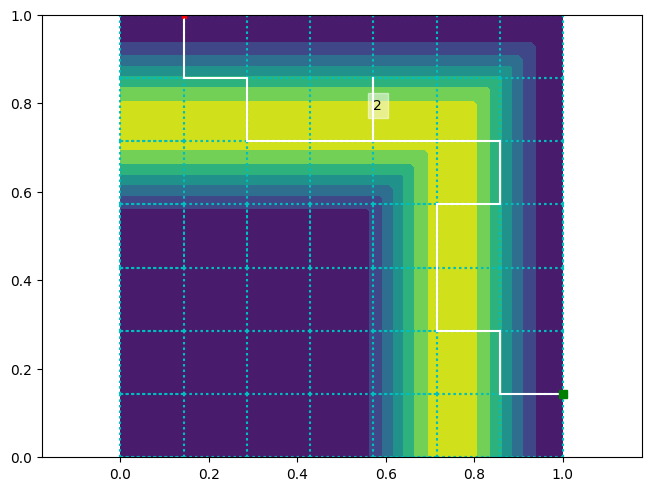

In [1219]:
fig,ax = plt.subplots(layout='constrained')
ax.contourf(x_grid,y_grid,my_pdf)
#ax.plot(x_wp,y_wp,'y+')
for (i,j) in links:
    plt.plot(wp_array[0,[i,j]],wp_array[1,[i,j]],'c:')
    if j>i:
        if link_use[(i,j)]>1:
            plt.text(0.5*sum(wp_array[0,[i,j]]),
                    0.5*sum(wp_array[1,[i,j]]),
                    f'{link_use[i,j]}',
                    bbox = dict(facecolor = 'white', alpha = 0.5, edgecolor='white'))
for (i,j) in moves:
    plt.plot(wp_array[0,[i,j]],wp_array[1,[i,j]],'w-')
plt.plot(wp_array[0,moves[0][0]],
         wp_array[1,moves[0][0]],
         'gs')
plt.plot(wp_array[0,moves[-1][1]],
         wp_array[1,moves[-1][1]],
         'r*')
ax.axis('equal')
plt.savefig(result_log['case'])
with open(result_log['case']+'.json', 'w') as f:
    json.dump(result_log,f)